# Group 27: Benedetto & Collura

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.

# Important note for grading
This notebook displays a series of questions, that we use to grade the work done. Since the following questions are rather basic, and do not change much from year to year, they only allow reaching the grade 10/20. Additional points can be gained by showing originality, depth, algorithmic design and implementations beyond that used in the notebook. Remember that this should become your own notebook: there is ample room for creativity!

# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 8.0)

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)

Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [41]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema)

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
How many distinct users do we have in our data? 

In [42]:
uniqueUsers = userArtistDF.select('userID').distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
How many distinct artists do we have in our data ?

In [43]:
uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


It is important to notice that this counter counts as different artists all the mispelled artists. For instance, referring to the example given above, "The Smiths", "Smiths, The", and "the smiths" would count as four different artists instead of counting as only one.
This is because here we are just considering the artistID of the `user_artist_data.txt` file, in this notebook we will give the real solution to this answer, using the `artist_alias.txt` file as well.

#### Question 1.3

One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than Integer.MAX_VALUE, or 2147483647, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.

What are the maximum and minimum values of column `userID` ?

HINT: Refer to section 4.3 of Laboratory 2.

In [44]:
userArtistDF.describe(['userID']).show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551818908|
|    min|                90|
|    max|           2443548|
+-------+------------------+



The minimum value is 90, the maximum one is 2443548.

#### Question 1.4
What is the maximum and minimum values of column `artistID` ?

In [45]:
userArtistDF.describe(['artistID']).show()

+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev| 2539389.092428367|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



The minimum value is 1, the maximum one is 10794401.

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
How many times each user has played a song? Show 5 samples of the result.

In [46]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy('userID').agg(sum('playCount').alias('totalPlayCount')).cache()
userActivity.show(5)

+-------+--------------+
| userID|totalPlayCount|
+-------+--------------+
|1000061|           244|
|1000070|         20200|
|1000313|           201|
|1000832|          1064|
|1000905|           214|
+-------+--------------+
only showing top 5 rows



We also decided to look at the top users considering the number of `PlayCounts`:

In [47]:
userActivityTop = userActivity.orderBy(desc('totalPlayCount')).cache()
userActivityTop.show(5)

+-------+--------------+
| userID|totalPlayCount|
+-------+--------------+
|1059637|        674412|
|2064012|        548427|
|2069337|        393515|
|2023977|        285978|
|1046559|        183972|
+-------+--------------+
only showing top 5 rows



We can already see, just looking at this table, the huge difference in `PlayCounts` between the top users, anyway we decided, in order to have a better idea of how users are distributed, to plot the distribution of users by `totalPlayCount` using two plots: in the first one (on the left) we represent the number of `playCount` for each user (users are sorted by decreasing `Playcount`), while in the one on the right we represent the percentage of users with the `playCount` in a given range (we consider 100 ranges of size `67` plus an "extra" range as accumulator).

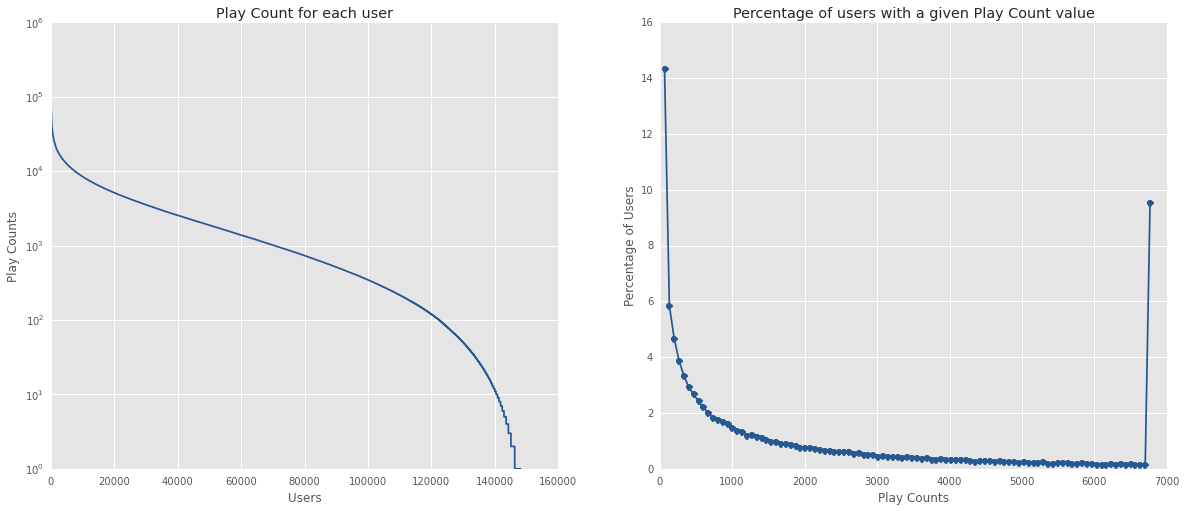

In [48]:
y = [x[1] for x in userActivityTop.collect()]
x = range(0, len(y))
plt.subplot(1, 2, 1)
plt.plot(x, y, color='#265993')
plt.title('Play Count for each user')
plt.yscale('log')
plt.ylabel('Play Counts')
plt.xlabel('Users')

plt.subplot(1, 2, 2)
x = []; y = []
k = 0
interval = int(userActivityTop.first().totalPlayCount / 10000) #as range we obtain 67
for i in range(0, 100):
    y.append(userActivityTop[userActivityTop.totalPlayCount > k][userActivityTop.totalPlayCount <= k + interval].count() / uniqueUsers * 100)
    x.append(k + interval)
    k += interval
y.append(userActivityTop[userActivityTop.totalPlayCount > k].count() / uniqueUsers * 100)
x.append(k + interval)
plt.title('Percentage of users with a given Play Count value')
plt.xlabel('Play Counts')
plt.ylabel('Percentage of Users')

plt.plot(x, y, 'o-', color='#265993')
plt.show()

In the first graph we decided to use a logarithmic scale for the `y` axis (representing the number of `Play Counts`) because the plot on a linear graph would have been too close to the axis, making impossible to observe the actual distribution of `Play Counts`.

Here we print some statistic about the second plot:

In [49]:
print('Interval size = ' + str(interval))
print('Percentages for the first 10 intervals: ')
for i in range(0,10):
    print('\t' + str(y[i]))
print('Percentage of the last interval: ' + str(y[100]))

Interval size = 67
Percentages for the first 10 intervals: 
	14.323716671955491
	5.8334627407822515
	4.6627191768335905
	3.8720959280539597
	3.330610150495237
	2.9261837405729487
	2.6702945763650234
	2.4177812586506064
	2.209829114650499
	2.005252817143899
Percentage of the last interval: 9.5374415134595


Contrary to our expectations - we believed to obtain a Gaussian distribution - we discovered that the actual distribution is exponential: a huge part of users - the majority - has very low `PlayCounts` and only a couple of them has used itnensively the service.
We decided to "cut" the distribution at a certain value, `6700`, and accumulate all the following users in a single huge interval because the graph would have been too close to the `x` axis and it wouldn't have been visible.
We can observe, indeed, that the percentages decrease very rapidly: we have the 14.3% of users in the range `[0;67)` and 5.8% in the second range. The accumulator interval we are using contains 9.54% of users, this could look like a huge percentage, in conflict with the exponential distribution, but we should consider that this last range goes from `6700` up to the max `PlayCount` (i.e. 674412)

In this first analysis we have just considered how many songs each user has played, without taking into account the artists of the songs he has listened to. Now we are going to focus also on this aspect.

First of all we print a sample of this table we obtained, containing all the information about how many times a certain user has listened to a song of a given artist.

In [50]:
userActivityPerArtist = userArtistDF.groupBy('userID','artistID')\
                .agg(sum('playCount').alias('PlayCountPerArtist')).cache()
userActivityPerArtist.show(10)

+-------+--------+------------------+
| userID|artistID|PlayCountPerArtist|
+-------+--------+------------------+
|1000002| 1000031|                47|
|1000002| 1003413|                 4|
|1000002| 1003557|                 1|
|1000002|     395|                 5|
|1000002|    5496|                 3|
|1000019| 1000796|                 1|
|1000019| 1003404|                 1|
|1000019| 1003773|                 1|
|1000019| 1003988|                 4|
|1000019| 1018378|                 1|
+-------+--------+------------------+
only showing top 10 rows



And now we can use the table just obtained to calculate how many different artists each user has been listening to.

In [51]:
userActivityArtist = userActivityPerArtist.groupBy('userID').count().cache()
userActivityArtist.show(10)

+-------+-----+
| userID|count|
+-------+-----+
|1068108|  532|
|1070733|  255|
|1071739|  759|
|1072983|   34|
|1073124|  124|
|1073708|  245|
|1074028|  271|
|1074105|  229|
|1074244|   96|
|1074388|  305|
+-------+-----+
only showing top 10 rows



It is important to highlight that we are still using the `artistIDs` without any kind of correction for the mispelled IDs. In the following part of the notebook we are going to solve this problem, because all the informations that we are getting here are not completely precise and this is the reason why we are not deeply analyzing these data.

#### Question 2.2
Plot CDF (or ECDF) of the number of play counts per User ID.

Explain and comment the figure you just created: 

* for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible.
* discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system.
* look at outliers and reason about their impact on your reccommender algorithm

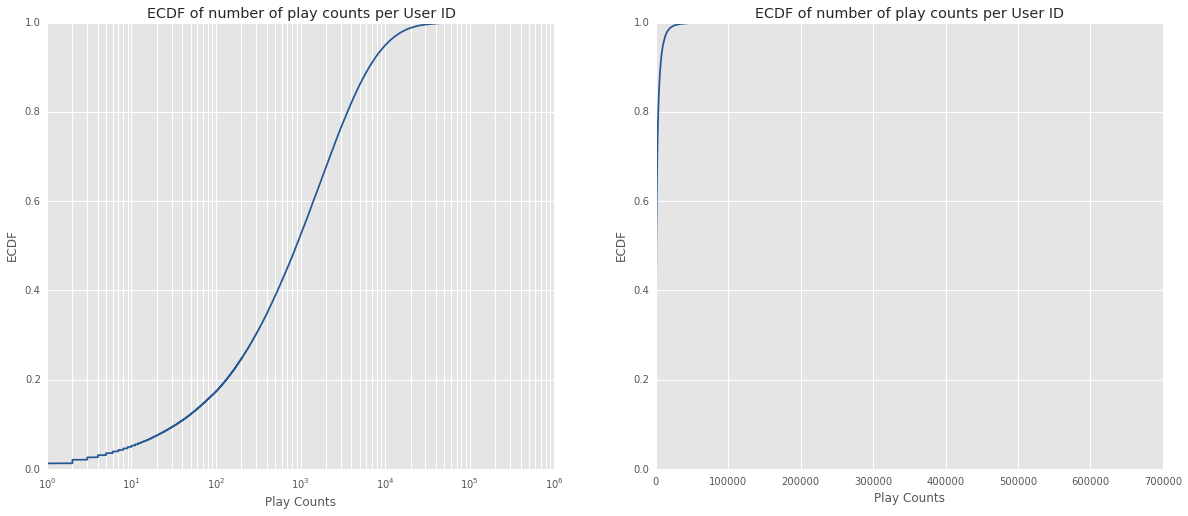

In [52]:
pdf = pd.DataFrame(data = userActivity.collect())
Y = np.sort(pdf[1])
yvals = np.arange(len(Y)) / float(len(Y))

plt.subplot(1, 2, 1)
plt.plot(Y, yvals, color='#265993')

plt.xscale('log') # we choose to use log scale to better appreciate the order of magnitude of playcounts 
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per User ID')

plt.subplot(1, 2, 2)
plt.plot(Y, yvals, color='#265993')
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per User ID')

plt.show()

We have plotted the ECDF twice, with two different scales: the one on the right, using linear axis, was our first plot but it is clear that we cannot get almost any information looking at it (we can just say that the growth is very fast); therefore we plotted the ECDF on a semi-log scale, to have a better idea oh how the ECDF grows.

We can observe that there is huge amount of users with a low `PlayCount` value and only a couple of them with a high one (as we have already seen while plotting the distribution).
Specifically, we can observe the percentage of users with `PlayCount` lower or equal to certain "key values":

In [53]:
for i in range(0,int(len(Y))):
    for j in [0.25, 0.50, 0.75, 0.90, 0.99, 0.999]:
        if yvals[i] <= j and yvals[i+1] > j:
            print('The  ' + str(j*100) + '% of user has up to ' + str(Y[i]) + ' PlayCounts')

The  25.0% of user has up to 204 PlayCounts
The  50.0% of user has up to 892 PlayCounts
The  75.0% of user has up to 2800 PlayCounts
The  90.0% of user has up to 6484 PlayCounts
The  99.0% of user has up to 21570 PlayCounts
The  99.9% of user has up to 50391 PlayCounts


We should be careful while considering outliers: as we have seen there are a couple of users with a huge value for PlayCount and many others with low values. In the same way, there are many artists with a very low number of songs played and few artists very popular (later on in the notebook we will analyze these data).
These outliers could have several effects: very popular artist could be recommended (almost) to anyone, but this recommendation could be not optimal in certain cases. In the same way, artists with a very low playcount could be penalized while performing the recommendation, even in the case they are similar to the "taste" of the user.
The problem with users is analogous, if a user has a very low number of playcounts it is very difficult to recommend a new artist to him, because we couldn't have enough data to do it. Talking about users, we should also consider his `curiosity`: it could be very difficult to recommend a new artist to a user with a very low curiosity, even in the case he has intensively used the service and has a huge `PlayCount`.

#### Question 2.3

How many play counts for each artist? Plot CDF or ECDF of the result.

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?

In [54]:
# We are interested in how many playcounts each artist has received.
artistActivityWrongDF = userArtistDF.groupBy('artistID').agg(sum('playCount').alias('totalPlayCount')).cache()
artistActivityWrongDF.show(5)

+--------+--------------+
|artistID|totalPlayCount|
+--------+--------------+
| 1007802|         23684|
| 1001530|        199573|
| 1071743|          3479|
| 1253025|          9028|
| 6623385|             2|
+--------+--------------+
only showing top 5 rows



Now we can plot the curve:

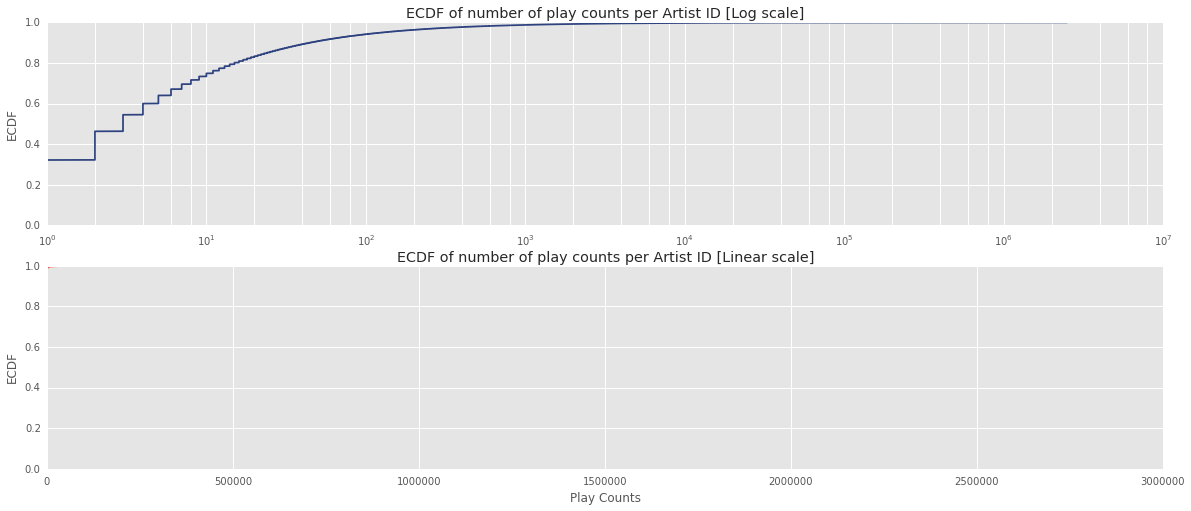

In [55]:
pdf = pd.DataFrame(data = artistActivityWrongDF.collect())
Y = np.sort(pdf[1])
yvals = np.arange(len(Y)) / float(len(Y))

plt.plot(Y, yvals, color='#2d427f')
plt.xscale('log') # we choose to use log scale to better appreciate the order of magnitude of playcounts 
#plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per Artist ID [Log scale]')

plt.subplot(2, 1, 2)
plt.plot(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per Artist ID [Linear scale]')

plt.show()

The plots are similar to the ones obtained while plotting the ECDF for users, and we are using two  plots with a different scale for the same reason as before. However, it is interesting to notice that in this case the increments are very fast, way faster that what we obtained for the userIDs.

As in the previous case, we can look at some key value to get an insight of how the curve is increasing.

In [56]:
for i in range(0,int(len(Y))):
    for j in [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]:
        if yvals[i] <= j and yvals[i+1] > j:
            print('The  ' + str(j*100) + '% of artists is up to ' + str(Y[i]) + ' PlayCounts')

The  25.0% of artists is up to 1 PlayCounts
The  50.0% of artists is up to 3 PlayCounts
The  75.0% of artists is up to 11 PlayCounts
The  90.0% of artists is up to 45 PlayCounts
The  99.0% of artists is up to 1402 PlayCounts
The  99.9% of artists is up to 34625 PlayCounts


#### Question 2.4
Plot a bar chart to show top 5 artists In terms of absolute play counts.

Comment the figure you just obtained:

* are these reasonable results?
* is looking at top-5 artists enough to learn more about your data?
* do you see anything strange in the data?

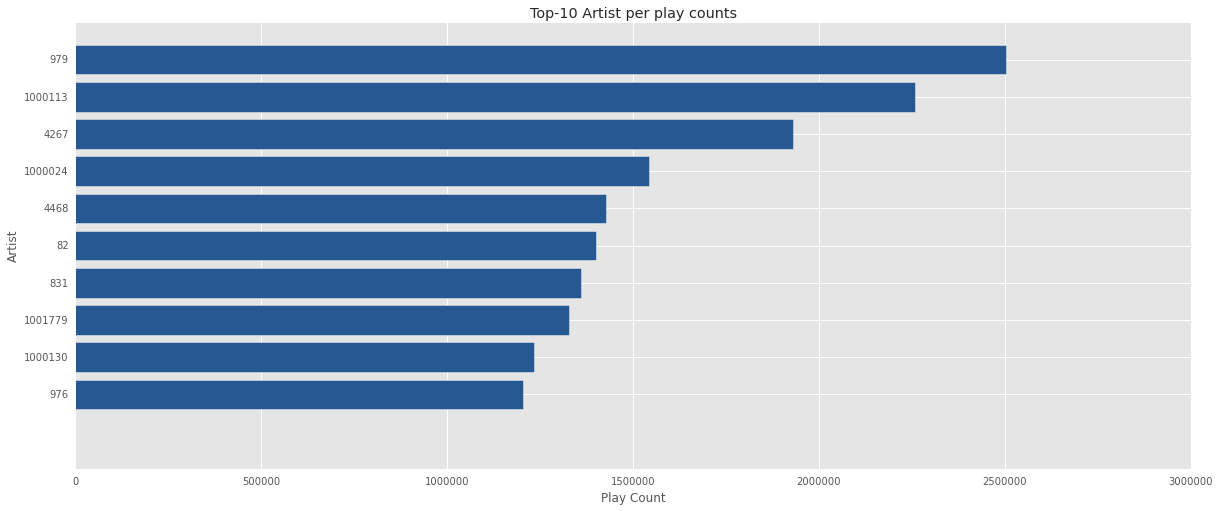

In [57]:
sortedArtistWrong = artistActivityWrongDF.orderBy(desc('totalPlayCount')).take(10)

artistID = [w['artistID'] for w in sortedArtistWrong]

y_pos = range(len(sortedArtistWrong))
frequency = [w['totalPlayCount'] for w in sortedArtistWrong]

plt.barh(y_pos, frequency[::-1], align='center', color='#265993')
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist per play counts')
plt.show()

In [58]:
artistActivityWrongDF.select(avg('totalPlayCount').alias('avgPlayCount')).show()

+------------------+
|      avgPlayCount|
+------------------+
|227.85566464830768|
+------------------+



All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.

HINT: If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

In [59]:
artistDataSchema = StructType([ \
    StructField('artistID', LongType(), True), \
    StructField('artistName', StringType(), True)])

artistDataDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_data.txt', schema = artistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDataDF.cache()

artistDataDF.show(5)

+--------+--------------------+
|artistID|          artistName|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
Find 20 artists whose name contains "Aerosmith". Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?

HINT: Function `locate(sub_string, string)` can be useful in this case.

In [60]:
# get artists whose name contains "Aerosmith"
artistDataDF[locate("Aerosmith", col('artistName')) > 0].show()

# show two examples
artistDataDF[artistDataDF.artistID == 1000010].show()
artistDataDF[artistDataDF.artistID == 2082323].show()

+--------+--------------------+
|artistID|          artistName|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+----------+
|artistID|artistName|
+--------+----------+
| 1000010| Aerosmith|
+--------+----------+

+--------+------------+
|artistID|  artistName|
+--------+------------+
| 2082323|01 Aerosmith|

The two names (and IDs) should be considered as the same artist - it is clear that the `01` in the second one is just an error - but now they are still being considered as different, and this is the problem we have talked about in all the considerations that we have done so far. Now we are going to solve this problem.

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.

In [61]:
artistAliasDataSchema = StructType([ \
    StructField('misspelledArtistID', LongType(), True), \
    StructField('standardArtistID', LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t') \
    .load(base + 'artist_alias.txt', schema = artistAliasDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()

artistAliasDF.show(5)

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           1092764|         1000311|
|           1095122|         1000557|
|           6708070|         1007267|
|          10088054|         1042317|
|           1195917|         1042317|
+------------------+----------------+
only showing top 5 rows



#### Question 3.4
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.

In [62]:
artistAliasDF[ artistAliasDF.misspelledArtistID == 1000010 ].show()
artistAliasDF[ artistAliasDF.misspelledArtistID == 2082323 ].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           2082323|         1000010|
+------------------+----------------+



We can see that for the first artistID we don't get any output, this means that the name corresponding to ID 1000010 is a correct one, as we supposed in the previous point. For the second one we get the correct redirection from the mispelled ID to the correct/standard one, and this confirms our idea: that `01` was just a mistake.

We decided to look at the most mispelled artists in our dataset and, possibly, try to analyze the type of errors and the causes.

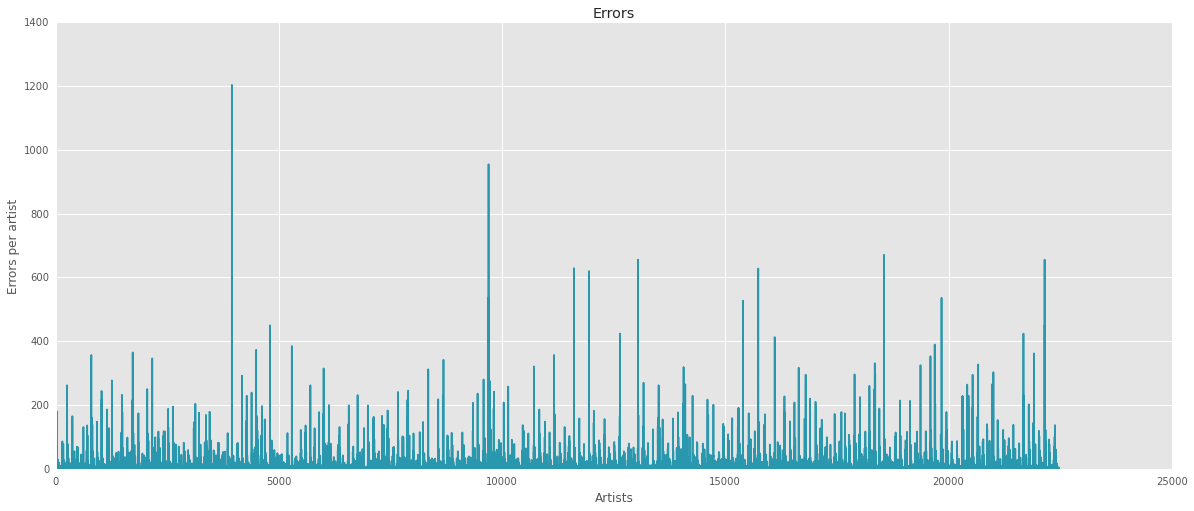

+-------+-----------------+
|summary|           errors|
+-------+-----------------+
|  count|            22478|
|   mean|8.492392561615802|
| stddev|28.89599180278597|
|    min|                1|
|    max|             1204|
+-------+-----------------+



In [63]:
artistErrorsDF = artistAliasDF.groupBy('standardArtistID').agg(count('misspelledArtistID').alias('errors')).cache()
artistErrors = artistErrorsDF.collect()

x = np.arange(0, len(artistErrors))
errors = [row['errors'] for row in artistErrors]

plt.figure()
plt.plot(x, errors, color='#2997ad')
plt.xlabel('Artists')
plt.ylabel('Errors per artist')
plt.title('Errors')
plt.show()

artistErrorsDF.describe('errors').show()

We discovered that there are `22478` artists that are mispelled once or more times, and on average, they are mispelled around 8.5 times: this is not too bad if we consider that this average is performed just over 22478 artist and in our whole dataset we have 1631028 artists.

But there's an artist that has more than 1000 errors! We are curious to see which one it is:

In [64]:
artistDataDF.join(artistErrorsDF[col('errors') > 1000], col('artistID') == col('standardArtistID')).show()

+--------+----------+----------------+------+
|artistID|artistName|standardArtistID|errors|
+--------+----------+----------------+------+
| 1000024| Metallica|         1000024|  1204|
+--------+----------+----------------+------+



We now wonder how difficult it is to spell Metallica (id `1000024`):

In [65]:
artistAliasDF[col('standardArtistID') == 1000024]\
        .join(artistActivityWrongDF, col('misspelledArtistID') == col('artistID'))\
        .groupBy('artistID').agg(sum('totalPlayCount').alias('totalPlayCount'))\
        .join(artistDataDF, 'artistID')\
        .orderBy(desc('totalPlayCount')).show(10, False)

+--------+--------------+---------------------------------------------------------------+
|artistID|totalPlayCount|artistName                                                     |
+--------+--------------+---------------------------------------------------------------+
|10217942|80            |Metallica  S&M                                                 |
|6899651 |58            |Metallica  (S&M)                                               |
|9967621 |50            |Metallica/San Francisco Symphony Orchestra                     |
|6972601 |17            |Metallica ft. London Orchestra                                 |
|10356204|17            |Metallica - S & M CD1                                          |
|10255321|14            |Metallica [United States]                                      |
|7028971 |14            |Metallica G.I.                                                 |
|10022129|12            |Metallica - Symphony & Metalli                                 |
|2080967 |

After a quick search, we found out that most of this erroneous data is coming from a particular Metallica performance: S&M (an abbreviation of Symphony and Metallica), a live album by American heavy metal band Metallica, with The San Francisco Symphony conducted by Michael Kamen. It was recorded on April 21–22, 1999 at The Berkeley Community Theatre.

Other most misspelled artists are:

In [66]:
artistErrorsDF.join(artistDataDF, col('standardArtistID') == col('artistID'))\
        .orderBy(desc('errors')).show(15, False)

+----------------+------+--------+---------------------+
|standardArtistID|errors|artistID|artistName           |
+----------------+------+--------+---------------------+
|1000024         |1204  |1000024 |Metallica            |
|1034635         |955   |1034635 |[unknown]            |
|82              |671   |82      |Pink Floyd           |
|1003694         |656   |1003694 |South Park           |
|1854            |656   |1854    |Linkin Park          |
|1000113         |629   |1000113 |The Beatles          |
|930             |628   |930     |Eminem               |
|979             |620   |979     |Radiohead            |
|1000107         |537   |1000107 |Iron Maiden          |
|976             |536   |976     |Nirvana              |
|1182            |527   |1182    |Delerium             |
|1205            |451   |1205    |U2                   |
|1274            |450   |1274    |Red Hot Chili Peppers|
|1001646         |424   |1001646 |The Smashing Pumpkins|
|4061            |424   |4061  

Looking at this table it is also interesting to notice that the second most mispelled "artist" is `[unknown]`. This makes sense, and it is just due to the fact that there are infinite possible way of write that the artist of a song is unknown; we actually expected to get it as the most mispelled one.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.

HINT: Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.

In [67]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

#### Question 4.2
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.

**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [68]:
def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 2.409579 seconds


#### Question 4.3
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task. 

We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. 

The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`

To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.


In [69]:
bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' % (t1 - t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.275962 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

In order to correct the mispelled IDs we decided to also use Spark SQL to test the differences in performance between the two versions.
First of all we create a table containing the totalPlayCount for each (real) artist.
The second one contains, for each user, the info about how many times he has listened to a certain artist.

In [70]:
t0 = time()
# userID | realArtistID | playCount
userStandardArtistDF = userArtistDF\
                        .join(artistAliasDF, col('artistID') == col('misspelledArtistID'), 'left_outer')
userStandardArtistDF = userStandardArtistDF\
                        .withColumn('realArtistID', coalesce(col('standardArtistID'), col('artistID')))\
                        .groupBy('userID','realArtistID').agg(sum('playCount').alias('playCount'))\
                        .drop('artistID', 'misspelledArtistID', 'standardArtistID').cache()
t1 = time()
print('The script for `userStandardArtistDF` takes %f seconds' % (t1 - t0))
userStandardArtistDF.show(5)

The script for `userStandardArtistDF` takes 0.703136 seconds
+-------+------------+---------+
| userID|realArtistID|playCount|
+-------+------------+---------+
|1062864|     1014555|        2|
|1062866|     1000175|      362|
|1062874|     1008762|        1|
|1062875|     1000591|        1|
|1062875|     1001277|        3|
+-------+------------+---------+
only showing top 5 rows



In [71]:
# realArtistID | totalPlayCount | artistName
t0 = time()
artistActivityDF = userStandardArtistDF.groupBy('realArtistID')\
                        .agg(sum('playCount').alias('totalPlayCount'))\
                        .join(artistDataDF, col('realArtistID') == col('artistID'), 'left_outer')\
                        .drop('artistID')\
                        .orderBy(desc('totalPlayCount'))\
                        .cache()
t1 = time()
print('The script for `artistActivityDF` takes %f seconds' % (t1 - t0))
artistActivityDF.show(5)        

The script for `artistActivityDF` takes 7.629519 seconds
+------------+--------------+----------------+
|realArtistID|totalPlayCount|      artistName|
+------------+--------------+----------------+
|         979|       2502596|       Radiohead|
|     1000113|       2259825|     The Beatles|
|        4267|       1931143|       Green Day|
|     1000024|       1543430|       Metallica|
|        4468|       1426254|System of a Down|
+------------+--------------+----------------+
only showing top 5 rows



In [72]:
# userID | realArtistID | playCount | artistName
t0 = time()
fullArtistActivityDF = userStandardArtistDF\
                        .join(artistDataDF, col('realArtistID') == col('artistID'), 'left_outer')\
                        .drop('artistID').cache()
t1 = time()
print('The script for `fullArtistActivityDF` takes %f seconds' % (t1 - t0))
fullArtistActivityDF.show(5)

The script for `fullArtistActivityDF` takes 0.146941 seconds
+-------+------------+---------+-------------+
| userID|realArtistID|playCount|   artistName|
+-------+------------+---------+-------------+
|2068678|          26|        1|Barry Adamson|
|1001468|          26|        1|Barry Adamson|
|1042791|          26|        1|Barry Adamson|
|2013742|          26|        1|Barry Adamson|
|2037719|          26|        3|Barry Adamson|
+-------+------------+---------+-------------+
only showing top 5 rows



#### Question 5.1

How many unique artists? Compare with the result when using old data.

In [74]:
realUniqueArtists = artistActivityDF.count()
print("Total n. of artists (old value): ", uniqueArtists)
print("Real n. of artists:", realUniqueArtists)
print("Index of correctness: %.4f" % (realUniqueArtists / uniqueArtists))

Total n. of artists (old value):  1631028
Real n. of artists: 1568126
Index of correctness: 0.9614


There is a difference of 62902 artist between the real value and the one we obtained counting all the mispelled artists. Considering the percentage there has been a reduction of `3.86%`, not a huge one, maybe, but it is still relevant.

#### Question 5.2

Who are the top-10 artistis?
  * In terms of absolute play counts

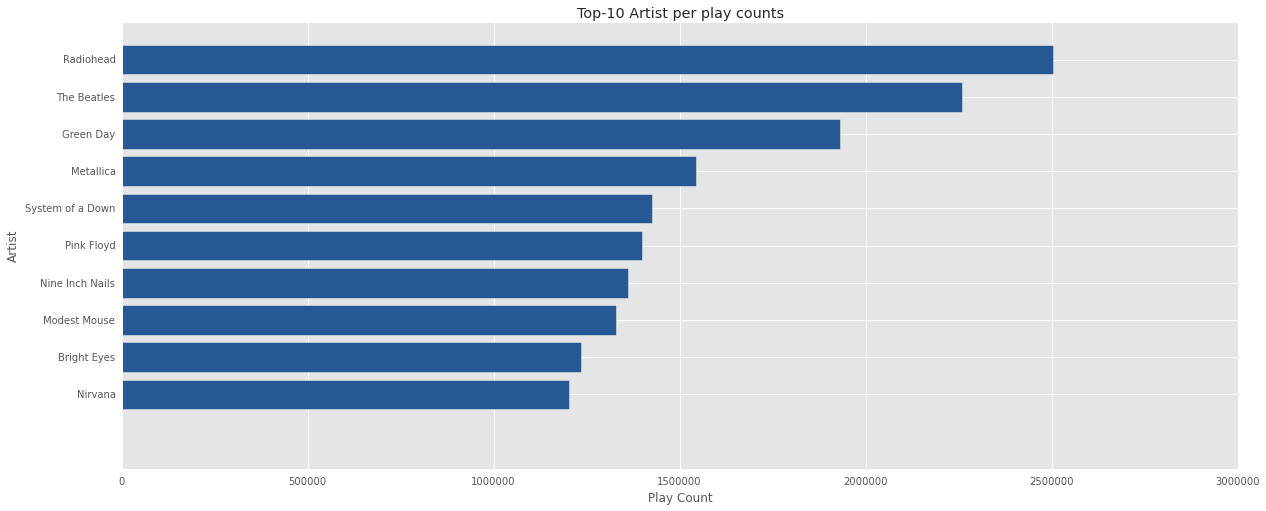

In [75]:
sortedArtist = artistActivityDF.take(10)
artistNames = [w['artistName'] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w['totalPlayCount'] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', color='#265993')
plt.yticks(y_pos, artistNames[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist per play counts')
plt.show()

In [76]:
artistActivityWrongDF.describe('totalPlayCount').show()
artistActivityDF.describe('totalPlayCount').show()

+-------+------------------+
|summary|    totalPlayCount|
+-------+------------------+
|  count|           1631028|
|   mean|227.85566464830768|
| stddev|  7988.11206711162|
|    min|                 1|
|    max|           2502130|
+-------+------------------+

+-------+------------------+
|summary|    totalPlayCount|
+-------+------------------+
|  count|           1568126|
|   mean|236.99560430730693|
| stddev| 8158.781640243099|
|    min|                 1|
|    max|           2502596|
+-------+------------------+



The average play count is a bit higher in the corrected dataset, because we don't 'lose' play counts on fake artists (wrong ID).
We can also notice that the top 4 artists are not changed compared to the plot with wrong data, because the difference between them was too big to be "covered" by the correction we performed. 

### Word cloud

It is entertaining to visually highlight the most famous group/artist among our users. For this purpose, we import the library *wordcloud* to perform such task. We select the 200 most popular artists in terms of play count.

In [77]:
%%capture
import pip

def install(package):
   pip.main(['install', package])

install('wordcloud') 

(-0.5, 1023.5, 399.5, -0.5)

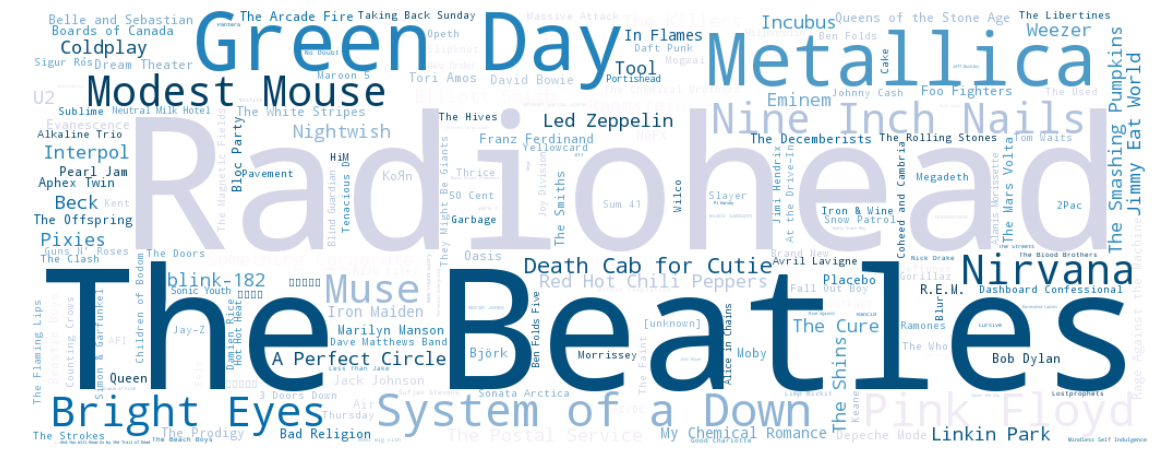

In [78]:
# wordmap
from wordcloud import WordCloud
artistActivityMap = artistActivityDF.orderBy(desc('totalPlayCount')).limit(200)\
                        .rdd.map(lambda row: (row['artistName'], row['totalPlayCount']))\
                        .collectAsMap()
wordcloud = WordCloud(background_color='white', width=1024, height=400, colormap='PuBu').generate_from_frequencies(artistActivityMap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

* In terms of "audience size", that is, how many users listened to one of their track at least once
  
Plot the results, and explain the figures you obtain.

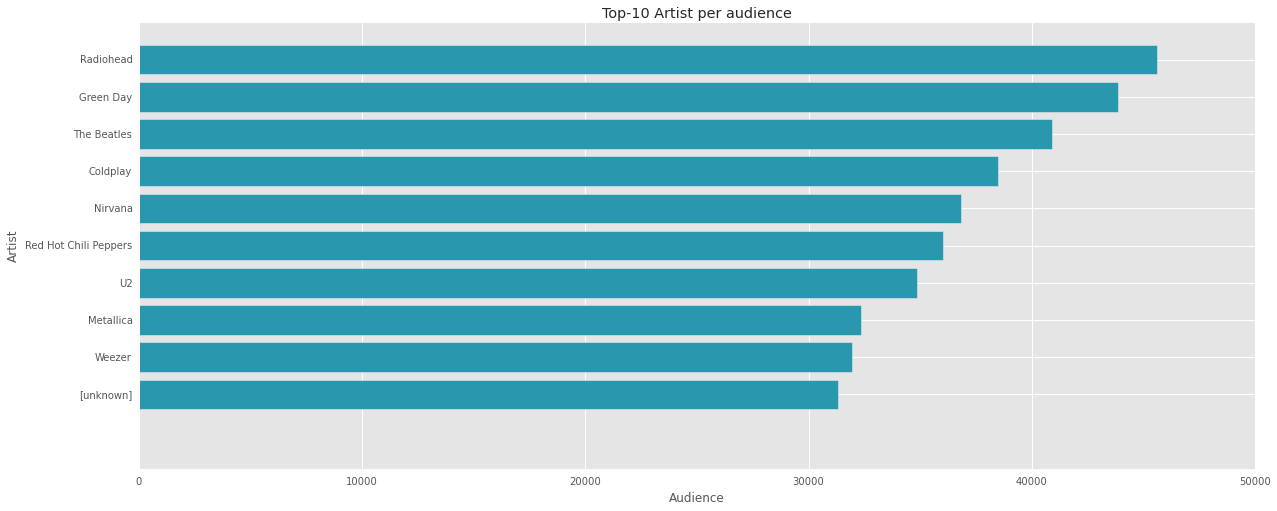

In [79]:
artistAudienceSizeDF = userStandardArtistDF.groupBy('realArtistID').agg(countDistinct(col('userID')).alias('audience'))
artistAudienceSizeDF = artistAudienceSizeDF.join(artistDataDF, col('realArtistID') == col('artistID'), 'left_outer').drop('artistID').orderBy(desc('audience')).cache()
best10Artists = artistAudienceSizeDF.take(10)
artistNames = [w['artistName'] for w in best10Artists]

y_pos = range(len(best10Artists))
frequency = [w['audience'] for w in best10Artists]

plt.barh(y_pos, frequency[::-1], align='center', color='#2997ad')
plt.yticks(y_pos, artistNames[::-1])
plt.xlabel('Audience')
plt.ylabel('Artist')
plt.title('Top-10 Artist per audience')
plt.show()

In [80]:
print('Stats about above graph:')
artistAudienceSizeDF.describe('audience').show()

Stats about above graph:
+-------+------------------+
|summary|          audience|
+-------+------------------+
|  count|           1568126|
|   mean|15.389901066623473|
| stddev|282.69785741132233|
|    min|                 1|
|    max|             45630|
+-------+------------------+



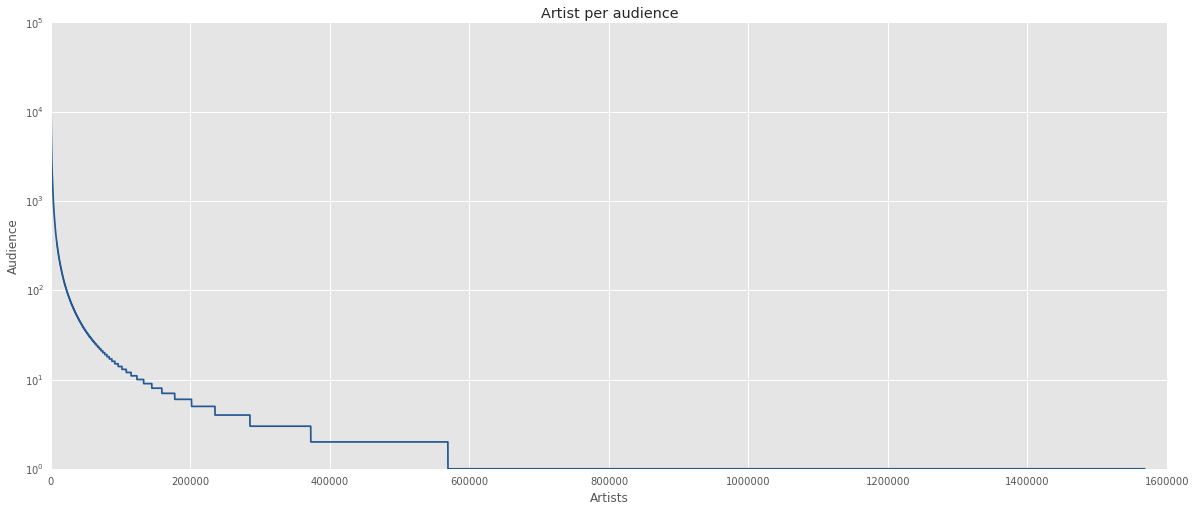

In [81]:
artistAudienceSize = artistAudienceSizeDF.collect()
plt.plot(range(0, len(artistAudienceSize)), [row['audience'] for row in artistAudienceSize], color='#265993')
plt.xlabel('Artists')
plt.ylabel('Audience')
plt.title('Artist per audience')
plt.yscale('log')
plt.show()

In average every artist is played by 15 diffent users. This confirms our previous graph, where very few artists had a very large audience, while most of them have an audience size below 10 and this is the same situation that we have always found in the dataset: a lot of very small values and some value really standing out.

We noticed that many of the top-artists by playcount are also in the second plot as top-artists by audience, thus we decided to take all the artists that are, at least, in one of the two plots and to plot these two features (playCount and audience) on the same plot.

In [82]:
artistAudiencePlayCountDF = artistAudienceSizeDF.orderBy(desc('audience')).limit(10).drop('audience')\
    .union(artistActivityDF.orderBy(desc('totalPlayCount')).limit(10).drop('totalPlayCount'))\
    .dropDuplicates(['artistName', 'realArtistID'])\
    .join(artistAudienceSizeDF.drop('artistName'), 'realArtistID')\
    .join(artistActivityDF.drop('artistName'), 'realArtistID').cache()

artistAudiencePlayCountDF.show(truncate=True)

+------------+--------------------+--------+--------------+
|realArtistID|          artistName|audience|totalPlayCount|
+------------+--------------------+--------+--------------+
|        3327|              Weezer|   31951|        977933|
|         831|     Nine Inch Nails|   25410|       1361977|
|     1000024|           Metallica|   32337|       1543430|
|        1274|Red Hot Chili Pep...|   36036|       1088701|
|     1001779|        Modest Mouse|   27731|       1328969|
|        4267|           Green Day|   43883|       1931143|
|     1034635|           [unknown]|   31324|        429447|
|     1000113|         The Beatles|   40919|       2259825|
|         979|           Radiohead|   45630|       2502596|
|        4468|    System of a Down|   27199|       1426254|
|     1000130|         Bright Eyes|   22159|       1234773|
|        1177|            Coldplay|   38497|       1001417|
|          82|          Pink Floyd|   30661|       1399665|
|         976|             Nirvana|   36

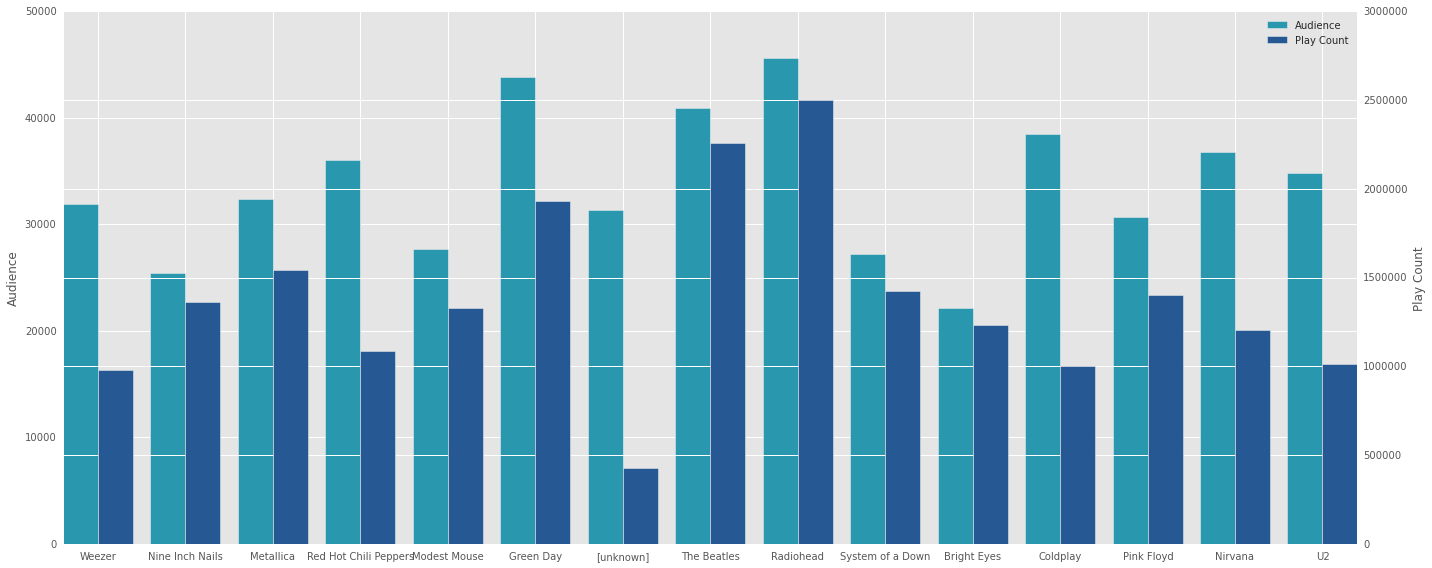

In [99]:
artistAudiencePlayCount = artistAudiencePlayCountDF.collect()
x = np.arange(len(artistAudiencePlayCount))
width = 0.4

fig, ax1 = plt.subplots() # Create matplotlib figure
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
plt.setp(ax1, xticks=x, xticklabels=[row['artistName'] for row in artistAudiencePlayCount])

ax1.bar(x - width, [row['audience'] for row in artistAudiencePlayCount], width=width, color='#2997ad', label='Audience')
ax2.bar(x, [row['totalPlayCount'] for row in artistAudiencePlayCount], width=width, color='#265993', label='Play Count')
ax1.set_ylabel('Audience')
ax2.set_ylabel('Play Count')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.tight_layout()
plt.xlabel('Artists')
plt.show()

We can see that there are really different behaviours: for instance, Radiohead are the top-artist both considering the audence and the number of PlayCounts, while `[unknown]` is in the top-10 considering the audience and is in a quite low position considering the total number of playcounts.

#### Question 5.3

Who are the top-10 users?
  * In terms of absolute play counts

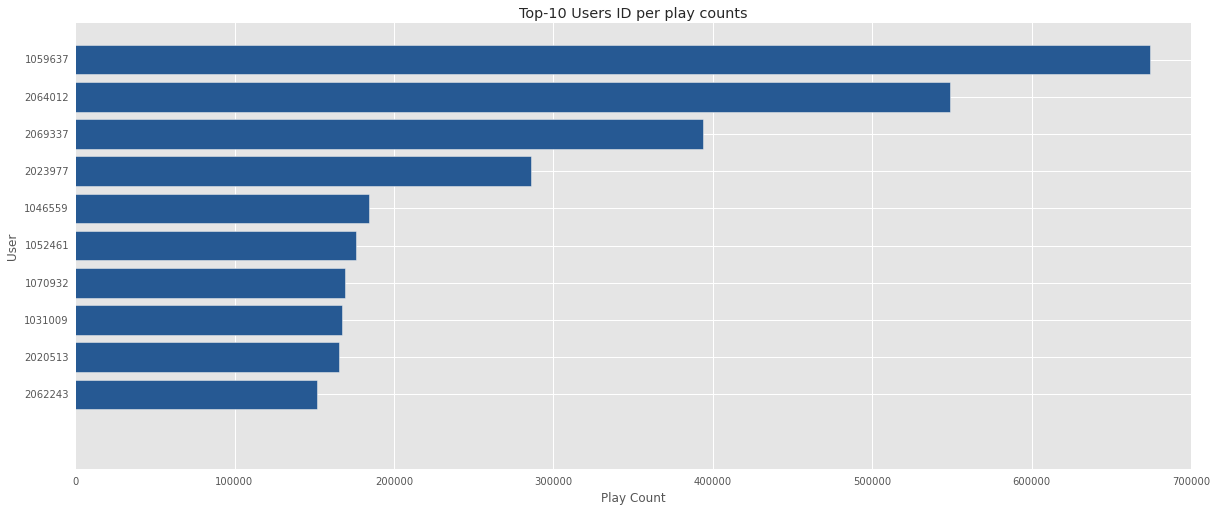

In [186]:
# calculate top 10 users interm of play counts
top10UsersByPlayCountDF = userStandardArtistDF.groupBy('userID').agg(sum('playCount').alias('totalPlayCount')).orderBy(desc('totalPlayCount')).cache()
top10UsersByPlayCount = top10UsersByPlayCountDF.take(10)

y_pos = range(len(top10UsersByPlayCount))
userIDs = [w['userID'] for w in top10UsersByPlayCount]
frequency = [w['totalPlayCount'] for w in top10UsersByPlayCount]

plt.barh(y_pos, frequency[::-1], align='center', color='#265993')
plt.yticks(y_pos, userIDs[::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

In [103]:
print('Stats about the above graph:')
top10UsersByPlayCountDF.describe('totalPlayCount').show()

Stats about the above graph:
+-------+------------------+
|summary|    totalPlayCount|
+-------+------------------+
|  count|            148111|
|   mean|2509.1922206993404|
| stddev| 5448.314385491495|
|    min|                 1|
|    max|            674412|
+-------+------------------+



* In terms of "curiosity", that is, how many different artists they listened to

Plot the results

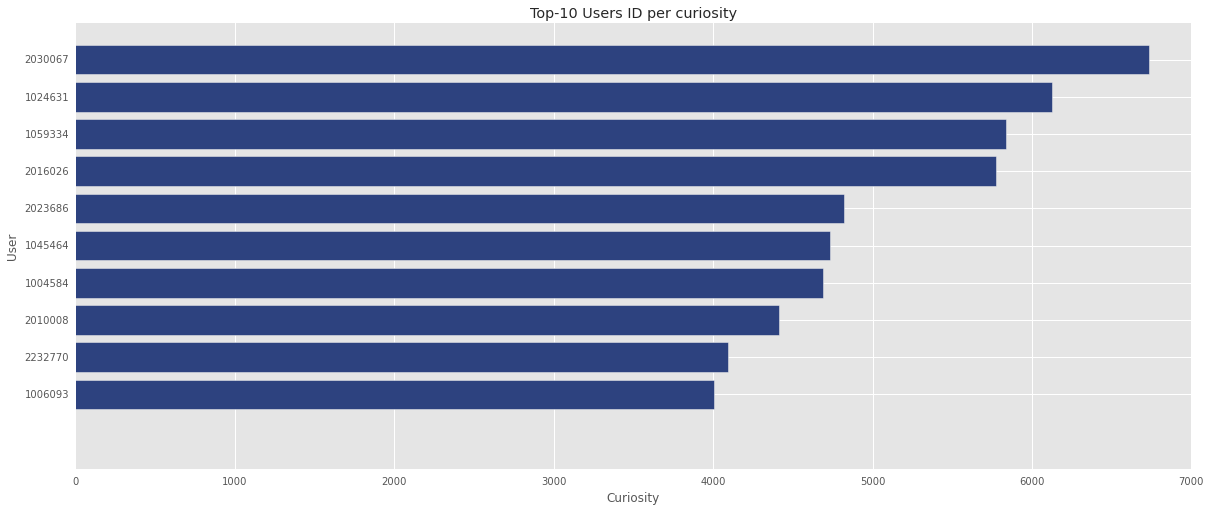

In [85]:
#calcolate top 10 users in term of "curiosity"
top10UsersByCuriosityDF = userStandardArtistDF.groupBy('userID').agg(countDistinct('realArtistID').alias('curiosity')).orderBy(desc('curiosity')).cache()
top10UsersByCuriosity = top10UsersByCuriosityDF.limit(10).collect()

y_pos = range(len(top10UsersByCuriosity))
userIDs = [w['userID'] for w in top10UsersByCuriosity]
curiosity = [w['curiosity'] for w in top10UsersByCuriosity]

plt.barh(y_pos, curiosity[::-1], align='center', color='#2d427f')
plt.yticks(y_pos, userIDs[::-1])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

In [86]:
print('Stats about the above graph:')
top10UsersByCuriosityDF.describe('curiosity').show()

Stats about the above graph:
+-------+------------------+
|summary|         curiosity|
+-------+------------------+
|  count|            148111|
|   mean| 162.9406593703371|
| stddev|215.77832725531024|
|    min|                 1|
|    max|              6735|
+-------+------------------+



### Curiosity

To correlate these two plots, and have more information about each user - information that can also be used in the recommendation system itself - we decided to define curiosity in this way:
$$curiosity = \frac{totalPlayCount}{numberOfDifferentArtists}$$
`curiosity = 1` means that a user has never listened more than one song from the same artist; `curiosity -> 0` means that the user has listened many many times the same artist (or couple of artists).

In [88]:
artistCount = userStandardArtistDF.groupBy('userID').agg(countDistinct('realArtistID').alias('artistCount'))
playCount = userStandardArtistDF.groupBy('userID').agg(sum('playCount').alias('playCount'))
artistPlayCountForUser = artistCount.join(playCount, 'userID').withColumn('curiosity', col('artistCount') / col('playCount')).cache()
artistPlayCountForUser.show(5)

print('Stats about curiosity of all users:')
artistPlayCountForUser.describe('curiosity').show(truncate=False)

+-------+-----------+---------+--------------------+
| userID|artistCount|playCount|           curiosity|
+-------+-----------+---------+--------------------+
|1000061|        111|      244| 0.45491803278688525|
|1000070|        133|    20200|0.006584158415841584|
|1000313|         27|      201| 0.13432835820895522|
|1000832|        259|     1064| 0.24342105263157895|
|1000905|         18|      214| 0.08411214953271028|
+-------+-----------+---------+--------------------+
only showing top 5 rows

Stats about curiosity of all users:
+-------+---------------------+
|summary|curiosity            |
+-------+---------------------+
|count  |148111               |
|mean   |0.19668037432306723  |
|stddev |0.2135979512890934   |
|min    |1.0393361377175084E-4|
|max    |1.0                  |
+-------+---------------------+



The minimum value for our user curiosity is `1.0393 * 10^(-4)`.

Here we tried to observe some info about the relation between the curiosity of a user and his number of playCount, sampling some user with characteristics we are interested in. However, a couple of cells below, there is a couple of plots where we analyze this relation in a more complete way.

In [89]:
artistPlayCountForUser[col('curiosity') < 0.001].orderBy(desc('playCount')).show(10, truncate=False)
artistPlayCountForUser[col('playCount') > 200000].show(truncate=False)
artistPlayCountForUser[col('curiosity') > 0.9].show(10, truncate=False)

+-------+-----------+---------+---------------------+
|userID |artistCount|playCount|curiosity            |
+-------+-----------+---------+---------------------+
|1059637|359        |674412   |5.323155578489114E-4 |
|2064012|57         |548427   |1.0393361377175084E-4|
|2069337|257        |393515   |6.530881923179549E-4 |
|2023977|67         |285978   |2.3428375609312605E-4|
|1070932|120        |168977   |7.101558200228433E-4 |
|2020513|122        |165642   |7.365281752212603E-4 |
|2017397|72         |134032   |5.371851498149696E-4 |
|1073421|65         |77485    |8.38872039749629E-4  |
|2054778|52         |56856    |9.145912480652878E-4 |
|1073616|25         |47781    |5.232205269877148E-4 |
+-------+-----------+---------+---------------------+
only showing top 10 rows

+-------+-----------+---------+---------------------+
|userID |artistCount|playCount|curiosity            |
+-------+-----------+---------+---------------------+
|2064012|57         |548427   |1.0393361377175084E-4|
|1

In this tables we can observe that, usually, people with a very high playCount have a low curiosity and also the opposite relation seems to be valid: if a user has a low curiosity he probably has a high playCount (later we will show that this relation is not completely true...).

How many users have listened one song for each artist they listened to?

In [90]:
artistPlayCountForUser[(col('artistCount') == col('playCount')) & (col('artistCount') > 20)].show(10)
print('Users that listened only a song from every artist (considering at least 20 playCount) are',
      artistPlayCountForUser[(col('artistCount') == col('playCount')) & (col('artistCount') > 20)].count())

+-------+-----------+---------+---------+
| userID|artistCount|playCount|curiosity|
+-------+-----------+---------+---------+
|2004302|         27|       27|      1.0|
|2332694|         54|       54|      1.0|
|2318544|         22|       22|      1.0|
|2441356|         23|       23|      1.0|
|2041901|         25|       25|      1.0|
|2021634|         26|       26|      1.0|
|1010033|         26|       26|      1.0|
|2420766|         26|       26|      1.0|
|1055642|         36|       36|      1.0|
|2165901|         23|       23|      1.0|
+-------+-----------+---------+---------+
only showing top 10 rows

Users that listened only a song from every artist (considering at least 20 playCount) are 23


In this part of the notebook we have analyzed the curiosity of each user. We have noticed that, reasonably, there are a lot of users that have listened one song for each artist they have been listening to only for low values of `playCount`. As we have shown, when we consider `playCount > 20` only 23 users have `curiosity = 1`.

As already said, we could use this couriosity in our recommendation algorithm, and later we are going to do it.

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


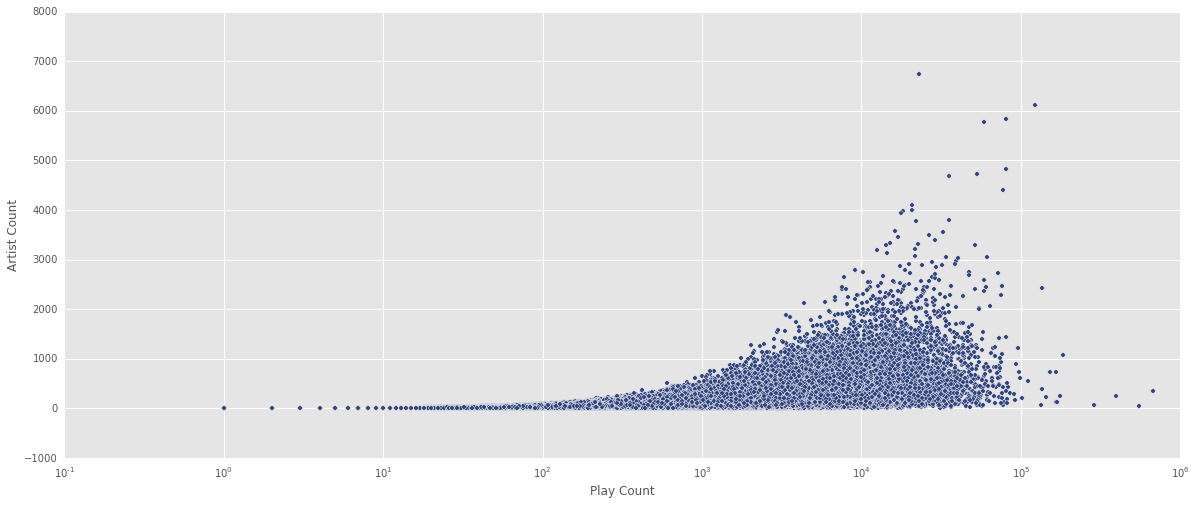

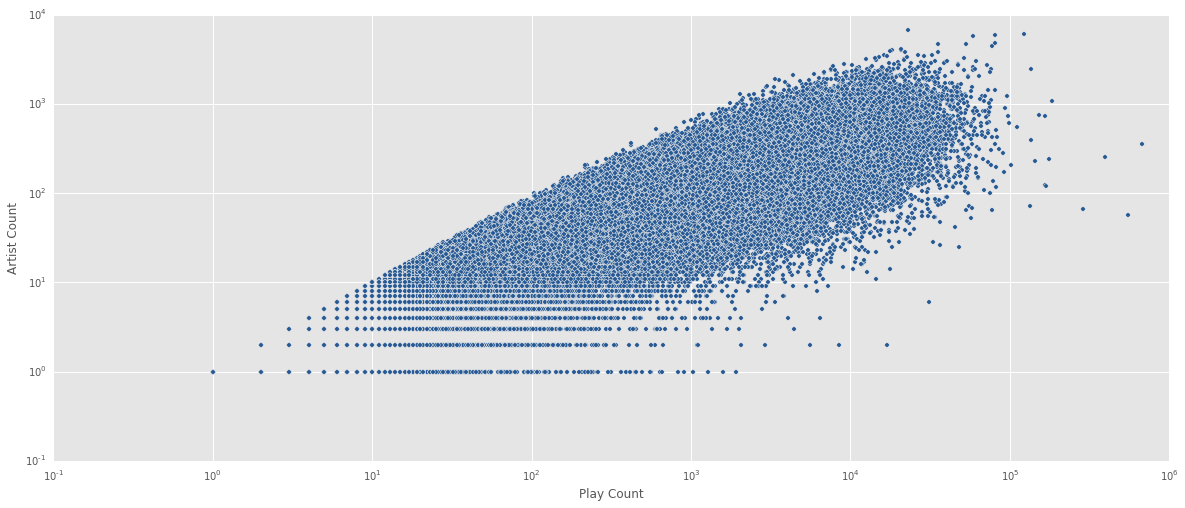

In [93]:
df = pd.DataFrame(data = artistPlayCountForUser.select('playCount', 'artistCount').collect())

plt.figure()
df.plot.scatter(x=0, y=1, logx=True, color='#2d427f')
plt.xlabel('Play Count')
plt.ylabel('Artist Count')

plt.figure()
df.plot.scatter(x=0, y=1, logx=True, logy=True, color='#265993')
plt.xlabel('Play Count')
plt.ylabel('Artist Count')

plt.show()

In these two graphs we are plotting users per curiosity, in the first one using a semi-log scale and in the second one using a log-log scale. Let's focus on the second one. Users with `curiosity = 1` are those on the bisector. We noticed that most of the users have a quite high value of curiosity, and there are only a couple of them have a really low value. Indeed, we can observe on the right part of the plot some user with a very high value for `playCount` while the number of different artists is not so high.
It is also interesting to notice the first horizontal line, at the bottom, that represents all the users that have listened only to one artist: we can see that there is a couple of users with more than `1000 playCounts`, not very curious users, indeed!

#### Correlation between artists

In all our analysis so far, we have not considered the correlation between different artists, i.e. how many "times" two artists have been listened by the same user. Here we are computing the correlation between artists and, after printing a sample of the table, we print a heatmap for the top-artists showing the correlation.

In [125]:
topArtists = userStandardArtistDF.groupBy('realArtistID')\
    .agg(sum('playCount').alias('totalPlayCount'))\
    .orderBy(desc('totalPlayCount')).limit(40).cache()
    
topArtistsUsers = topArtists.join(userStandardArtistDF, 'realArtistID').drop('totalPlayCount', 'playCount').cache()

# FIXME: improve query
artistArtist = topArtistsUsers\
    .join(topArtistsUsers.withColumnRenamed('realArtistID', 'corealArtistID'), 'userID')\
    .join(artistDataDF, col('realArtistID') == col('artistID'), 'left_outer').drop('realArtistID', 'artistID')\
    .join(artistDataDF.withColumnRenamed('artistName', 'artistName2'), col('corealArtistID') == col('artistID'), 'left_outer')\
    .drop('corealArtistID', 'artistID').cache()

In [ ]:
df = artistArtist.toPandas()
# Spark equivalent: artistArtist.stat.crosstab("artistName", "artistName2")
ct = pd.crosstab(df.artistName, df.artistName2).corr()
ct.head()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


artistName2,A Perfect Circle,Beck,Bright Eyes,Coldplay,Death Cab for Cutie,Elliott Smith,Eminem,Green Day,In Flames,Incubus,Interpol,Iron Maiden,Jimmy Eat World,Led Zeppelin,Linkin Park,Metallica,Modest Mouse,Muse,My Chemical Romance,Nightwish,Nine Inch Nails,Nirvana,Pink Floyd,Pixies,Queens of the Stone Age,Radiohead,Rammstein,Red Hot Chili Peppers,Something Corporate,System of a Down,The Beatles,The Cure,The Killers,The Postal Service,The Shins,The Smashing Pumpkins,Tool,U2,Weezer,blink-182
artistName2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Perfect Circle,1.000000,0.183842,-0.059726,0.314364,-0.035590,-0.052703,0.297944,0.406235,0.195363,0.530913,0.055083,0.203370,0.219822,0.393605,0.402538,0.462971,0.112361,0.386908,0.035880,0.150829,0.596056,0.487223,0.404906,0.165603,0.489824,0.383348,0.394637,0.467512,-0.057976,0.550689,0.269171,0.245654,0.171202,0.002692,-0.029518,0.458526,0.763271,0.333167,0.283784,0.283556
Beck,0.183842,1.000000,0.628095,0.651523,0.620372,0.709337,0.242150,0.381815,-0.396189,0.314921,0.711972,-0.192635,0.375554,0.489745,0.036163,0.036131,0.724832,0.466142,0.114672,-0.328004,0.415230,0.484098,0.489328,0.733104,0.434770,0.760687,-0.084335,0.414599,0.190250,0.057720,0.698788,0.649443,0.543132,0.649349,0.704892,0.636188,0.180675,0.522697,0.676412,0.239903
Bright Eyes,-0.059726,0.628095,1.000000,0.506027,0.836253,0.796893,0.007179,0.212448,-0.604118,0.150902,0.758721,-0.473154,0.435196,0.170000,-0.194937,-0.297858,0.765272,0.332304,0.349625,-0.564972,0.110626,0.171900,0.166012,0.604356,0.149063,0.565581,-0.392514,0.108386,0.423666,-0.221362,0.473508,0.534309,0.583004,0.811183,0.811849,0.393541,-0.132707,0.245017,0.567728,0.154294
Coldplay,0.314364,0.651523,0.506027,1.000000,0.542909,0.529869,0.473786,0.616105,-0.225662,0.561632,0.576980,-0.026126,0.568424,0.539361,0.371003,0.252409,0.620537,0.629842,0.266071,-0.107652,0.405567,0.597367,0.538538,0.581013,0.497956,0.766120,0.128501,0.634243,0.373201,0.284045,0.700310,0.613374,0.657451,0.580272,0.602810,0.655151,0.259656,0.717433,0.694301,0.516385
Death Cab for Cutie,-0.035590,0.620372,0.836253,0.542909,1.000000,0.783553,0.033512,0.243846,-0.608717,0.206216,0.758123,-0.485425,0.507719,0.175734,-0.154349,-0.294782,0.797629,0.338245,0.387880,-0.571488,0.107906,0.172175,0.165757,0.586245,0.141154,0.568545,-0.394036,0.133607,0.494014,-0.209567,0.470730,0.523933,0.608455,0.880825,0.840327,0.409867,-0.117964,0.265733,0.597793,0.203220


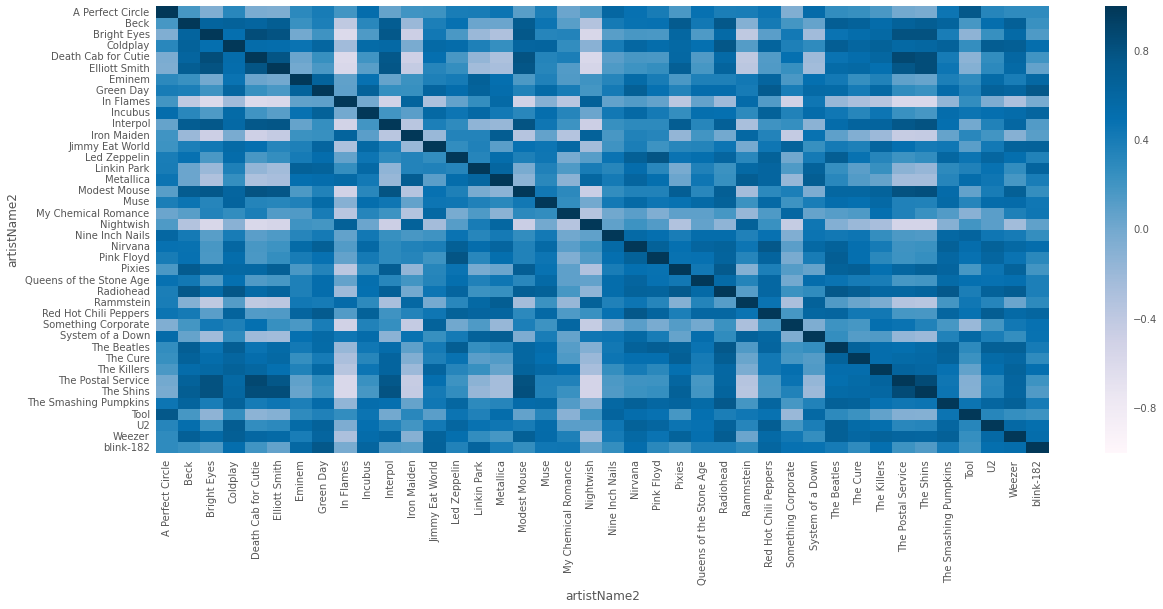

In [174]:
sns.heatmap(ct, cmap='PuBu')

As said before, in this plot we are analyzing the correlation between couple of aritsts, we have plotted the result only for the 40 most listened artist for simplicity reasons.

We can observe that Radiohead has a quite high correlation with most of the other artists in this plot: this makes sense since they are the most popular artist by far.

It is also interesting to notice that *In Flames* (a Swedish heavy metal band) and *Nightwish* (a symphonic metal band from Finland) have a quite high correlation between them and a similar (quite low) correlation with other bands. Let's analyze this correlation a bit more deeply...

In [127]:
pd.set_option('display.max_columns', None)
ct.loc[['In Flames', 'Nightwish']]

artistName2,A Perfect Circle,Beck,Bright Eyes,Coldplay,Death Cab for Cutie,Elliott Smith,Eminem,Green Day,In Flames,Incubus,Interpol,Iron Maiden,Jimmy Eat World,Led Zeppelin,Linkin Park,Metallica,Modest Mouse,Muse,My Chemical Romance,Nightwish,Nine Inch Nails,Nirvana,Pink Floyd,Pixies,Queens of the Stone Age,Radiohead,Rammstein,Red Hot Chili Peppers,Something Corporate,System of a Down,The Beatles,The Cure,The Killers,The Postal Service,The Shins,The Smashing Pumpkins,Tool,U2,Weezer,blink-182
artistName2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
In Flames,0.195363,-0.396189,-0.604118,-0.225662,-0.608717,-0.585037,0.084269,0.089691,1.000000,0.007714,-0.518131,0.639736,-0.293655,0.063678,0.265256,0.566830,-0.507215,-0.090099,-0.359428,0.665968,0.072554,0.138365,0.065732,-0.367396,0.064554,-0.206275,0.551884,0.13841,-0.506586,0.447835,-0.174600,-0.275499,-0.351301,-0.578471,-0.583076,-0.141826,0.266022,-0.045350,-0.285332,-0.020344
Nightwish,0.150829,-0.328004,-0.564972,-0.107652,-0.571488,-0.539997,0.211052,0.191122,0.665968,0.038729,-0.474045,0.656037,-0.237817,0.117999,0.401450,0.608172,-0.466073,0.007318,-0.339417,1.000000,0.079661,0.222068,0.135556,-0.312974,0.063592,-0.133257,0.657544,0.24080,-0.437338,0.451655,-0.073462,-0.189996,-0.260927,-0.535771,-0.536000,-0.092709,0.199210,0.108495,-0.230246,0.078807


In [128]:
ct[['In Flames', 'Nightwish']][(ct['In Flames'] > 0.5) | (ct['Nightwish'] > 0.5)]

artistName2,In Flames,Nightwish
artistName2,,
In Flames,1.000000,0.665968
Iron Maiden,0.639736,0.656037
Metallica,0.566830,0.608172
Nightwish,0.665968,1.000000
Rammstein,0.551884,0.657544


We can see that the artist with a high (considering > 0.5 as "high") correlation with *In Flames* and *Nightwish* are the same and they are few (*Iron Maiden*, *Metallica*, *Rammstein*). We have compared this result with the one obtained for Radiohead and there is a huge difference: 25 artists out of 40 have a high (> 0.5) correlation with them!

In [129]:
radiohead = ct[['Radiohead']][(ct['Radiohead'] > 0.5)]
print('# of groups highly correlated to Radiohead:', radiohead['Radiohead'].count(), 'over', ct['Radiohead'].count(), 'groups')
radiohead

# of groups highly correlated to Radiohead: 25 over 40 groups


artistName2,Radiohead
artistName2,
Beck,0.760687
Bright Eyes,0.565581
Coldplay,0.766120
Death Cab for Cutie,0.568545
Elliott Smith,0.635658
Green Day,0.524724
Interpol,0.679381
Led Zeppelin,0.618810
Modest Mouse,0.692368


Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is converged. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we init the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row from $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:

Initialize $X$, $Y$

**while**(convergence is not true) **do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**

For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute 􏰀$\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute 􏰁$\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [2]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (rawArtistAlias
                # extract fields using function xtractFields
                .map(xtractFields)
                # filter out the special tuples
                .filter(lambda x: x[0] != -1)
                # collect result to the driver as a "dictionary"
                .collectAsMap())

#### Question 6.2
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.

HINT: Using broadcast varible can help us increase the effiency.

In [3]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

[('1000002', '1', '55'),
 ('1000002', '1000006', '33'),
 ('1000002', '1000007', '8'),
 ('1000002', '1000009', '144'),
 ('1000002', '1000010', '314')]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.

In [4]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

allData = userArtistDataRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(sc.defaultParallelism).cache()

#### Question 7.2
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
* `training data` is the input data you decide to feed to the ALS algorithm
* `rank` is the number of laten features

We can also use some additional parameters to adjust the quality of the model. Currently, let's set 

In [5]:
rank = 10
iterations = 5
lambda_ = 0.01
alpha = 1.0

to build model.

In [6]:
t0 = time()
model = ALS.trainImplicit(allData, rank, iterations, lambda_ = lambda_, alpha = alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 161.349683 secs


#### Question 7.3
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [7]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save(sc, 'lastfm_model.spark')

Deleted lastfm_model.spark


#### Question 7.4
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.

In [8]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'lastfm_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 2.295594 secs


#### Question 7.5
Print the first row of user features in our model.

In [9]:
model.userFeatures().first()

(120,
 array('d', [-0.1352561116218567, 0.008700226433575153, 0.22792120277881622, -0.24764378368854523, -0.01167862955480814, 0.06011184677481651, 0.27485305070877075, -0.17320315539836884, -0.09144344925880432, 0.023747051134705544]))

### Question 8
Show the top-5 artist names recommendated for user `2093760`.

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [17]:
# Make five recommendations to user 2093760
recommendations = model.recommendProducts(2093760, 5)

# construct set of recommendated artists
recArtist = set([x[1] for x in recommendations])

# construct data of artists (artist_id, artist_name)
userID = 2093760
rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1, "")
    else: 
        return (-1, "")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
playedProductIDs = set(allData.filter(lambda x: x[0] == userID).map(lambda x: x[1]).collect())

userList = artistByID.filter(lambda x: x[0] in playedProductIDs).values().collect()
recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()

print('What the user listened to:', userList)
print('What the user should listen to:', recList)

What the user listened to: ['David Gray', 'Blackalicious', 'Jurassic 5', 'The Saw Doctors', 'Xzibit']
What the user should listen to: ['50 Cent', 'Jay-Z', 'Ludacris', '2Pac', 'The Game']


#### IMPORTANT NOTE

At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.

In [19]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:

In [12]:
rank = 10
iterations = 5
lambda_ = 0.01
alpha = 1.0

In [13]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(trainData, rank, iterations, lambda_ = lambda_, alpha = alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 60.702872 secs


#### Area under the ROC curve: a function to compute it

In [14]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [25]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

In [16]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.964972630243061
finish in 46.782011 seconds


#### Question 9.3
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective. 

Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.

In [17]:
# r[0] = userID, r[1] = artistID, r[2] = playCount
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x, y: x + y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

auc = calculateAUC(cvData, bListenCount, predictMostListened)
print(auc)

0.936606917269056


## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.

In [18]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank, iterations, lambda_ = lambda_, alpha = alpha)
            auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)

            evaluations.append(((rank, lambda_, alpha), auc))

            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [19]:
evaluations.sort(key = lambda x: x[1], reverse = True)

evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0     (10, 1.0, 40.0)  0.976204
1  (10, 0.0001, 40.0)  0.975868
2     (50, 1.0, 40.0)  0.975671
3  (50, 0.0001, 40.0)  0.974831
4      (10, 1.0, 1.0)  0.969764
5      (50, 1.0, 1.0)  0.966731
6   (10, 0.0001, 1.0)  0.964429
7   (50, 0.0001, 1.0)  0.953104


PythonRDD[186] at RDD at PythonRDD.scala:48

The best parameters, `rank`, `lambda_`, `alpha`, are given by: `10, 1.0, 40.0`

#### Question 10.2 

Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user 2093760.

In [32]:
rank = 10
lambda_ = 1.0
alpha = 40.0

model = ALS.trainImplicit(allData, rank, iterations, lambda_ = lambda_, alpha = alpha)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(2093760,5)

recommendedProductIDs = set( [x[1] for x in recommendations] )

recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()
print(recList)

['50 Cent', 'Jay-Z', 'Ludacris', '2Pac', 'The Game']


Previously we recommended: `['50 Cent', 'Jay-Z', 'Ludacris', '2Pac', 'The Game']`

We can notice that the recommendation made with the *optimized* parameters doesn't change (at least for this user).

Let's try with someone else, we consider one of the user with the highest curiosity, one with few play counts and one in between, picked randomly.

| UserID | Profile |
|---------|--------|
| 1024631 | very high artist count |
| 1008961 | low play count, low artist count |
| 2017397 | high playcount, low artist count

In [23]:
users = [ 1024631, 1008961, 2017397 ]
for user in users:
    recommendations = model.recommendProducts(user, 5)
    recommendedProductIDs = set([x[1] for x in recommendations])
    
    artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
    playedProductIDs = set(allData.filter(lambda x: x[0] == user).map(lambda x: x[1]).collect())

    userList = artistByID.filter(lambda x: x[0] in playedProductIDs).values().collect()
    recList = artistByID.filter(lambda x: x[0] in recommendedProductIDs).values().collect()

    #print('What the user %s listened to:' % user, userList)
    print('What the user %s should listen to:' % user, recList)

What the user 1024631 should listen to: ['Milla', 'Scott Weiland', 'David Rovics', 'Los Straitjackets', 'Mira']
What the user 1008961 should listen to: ['[unknown]', 'The Killers', 'U2', 'Green Day', 'blink-182']
What the user 2017397 should listen to: ['Sunk Loto', 'Killradio', 'Joey Cape and Tony Sly', 'Fightstar', 'One Dollar Short']


Recommending `unknown` is definetely not a good recommendation, below we are going to solve this problem.

In [ ]:
unpersist(model)

### Cross validation with K-fold

K-fold cross validation is one way to improve over the holdout method. The data set is divided into k subsets, and the holdout method is repeated k times. Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed. The advantage of this method is that it matters less how the data gets divided. Every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times. The variance of the resulting estimate is reduced as k is increased. The disadvantage of this method is that the training algorithm has to be rerun from scratch k times, which means it takes k times as much computation to make an evaluation. A variant of this method is to randomly divide the data into a test and training set k different times. The advantage of doing this is that you can independently choose how large each test set is and how many trials you average over. 

We therefore utilize the variant with $k$ different random splits, which is easier to implement due to our dataset size.

In [26]:
k = 10
auc = []
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)


for i in range(k):
    trainDataTmp, cvDataTmp = allData.randomSplit([0.9, 0.1])
    trainDataTmp.cache()
    cvDataTmp.cache()

    t0 = time()
    model = ALS.trainImplicit(trainDataTmp, rank, iterations, lambda_ = lambda_, alpha = alpha)
    t1 = time()
    print("finish training model in %f secs" % (t1 - t0))
    # Get all unique artistId, and broadcast them
    t0 = time()
    auc.append( calculateAUC(cvDataTmp, bAllItemIDs, model.predictAll) )
    t1 = time()
    print("finish in %f seconds" % (t1 - t0))
    unpersist(model)
    
print(auc)
print(__builtin__.sum(auc) / float(len(auc)))

finish training model in 72.634741 secs
finish in 61.050476 seconds
finish training model in 77.220618 secs
finish in 65.560372 seconds
finish training model in 67.689447 secs
finish in 43.464636 seconds
finish training model in 56.024920 secs
finish in 42.603644 seconds
finish training model in 64.253388 secs
finish in 54.742219 seconds
finish training model in 62.711014 secs
finish in 46.059854 seconds
finish training model in 56.141541 secs
finish in 48.582432 seconds
finish training model in 55.270126 secs
finish in 43.022710 seconds
finish training model in 66.329278 secs
finish in 46.802134 seconds
finish training model in 60.358159 secs
finish in 46.313996 seconds
[0.9754003355756703, 0.9760570347672795, 0.9767029003526587, 0.976007127419101, 0.9760723868059501, 0.9756866302013937, 0.9762971571415436, 0.9758170169928766, 0.9762615802278226, 0.9767910654930484]
0.9761093234977345


In [30]:
print('Min:', __builtin__.min(auc))
print('Max:', __builtin__.max(auc))
print('Avg:', __builtin__.sum(auc) / float(len(auc)))

Min: 0.9754003355756703
Max: 0.9767910654930484
Avg: 0.9761093234977345


As we can see from our k-fold cross-validation, our model keeps an accuracy of 97.6%, thus there are no huge differences in the accuracy depending on how we split the data.

### Recommender without unknowns

We may want to remove from our dataset the artists with `unknown` as label, it just makes no sense to recommend the artist `unknown` to an user.

In [38]:
allDataWoUnknowns = userArtistDataRDD.filter(lambda r: r[1] != '1034635')\
            .map(lambda r: Rating(r[0], r[1], r[2])).repartition(sc.defaultParallelism).cache()
    
rank = 10
lambda_ = 1.0
alpha = 40.0

model = ALS.trainImplicit(allDataWoUnknowns, rank, iterations, lambda_ = lambda_, alpha = alpha)
allData.unpersist()

users = [ 1024631, 1008961, 2017397 ]
for user in users:
    recommendations = model.recommendProducts(user, 5)
    recommendedProductIDs = set([x[1] for x in recommendations])
    
    artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
    playedProductIDs = set(allData.filter(lambda x: x[0] == user).map(lambda x: x[1]).collect())

    userList = artistByID.filter(lambda x: x[0] in playedProductIDs).values().collect()
    recList = artistByID.filter(lambda x: x[0] in recommendedProductIDs).values().collect()

    #print('What the user %s listened to:' % user, userList)
    print('What the user %s should listen to:' % user, recList)

What the user 1024631 should listen to: ['Red Delicious', 'Anthony Stewart Head', 'Ghost Of The Robot', 'Lionel Richie & The Commodores', 'Vision']
What the user 1008961 should listen to: ['The Killers', 'Coldplay', 'U2', 'Green Day', 'blink-182']
What the user 2017397 should listen to: ['Atreyu', 'Fightstar', 'Rooster', 'InMe', 'Blindside']


Previously we suggested:
```
What the user 1024631 should listen to: ['Milla', 'Scott Weiland', 'David Rovics', 'Los Straitjackets', 'Mira']
What the user 1008961 should listen to: ['[unknown]', 'The Killers', 'U2', 'Green Day', 'blink-182']
What the user 2017397 should listen to: ['Sunk Loto', 'Killradio', 'Joey Cape and Tony Sly', 'Fightstar', 'One Dollar Short']
```

As we can see, the user with a very high play count and artist count got a completely different set of recommendations. This is due to the fact that he's linked to many different artists and even a small change in the dataset can modify the output.

For the second user, that had a very low artist count and a very low artist count, the recommendations don't change, because the algorithm tends to recommend the most popular artists, since it's based on the play count for each artist.

The third user, with high playcount and low artist count, still gets suggestions related to different styles of rock music, maily punk-rock and alternative rock, which appear to be his preference.

## 3.7 Tuning the recommendation system

We have been working all this time splitting data in the training set and the cv set using a ratio 0.9:0.1 and we have no way, so far, to be sure that this is the best choice to split tha data. Thus, before proposing a recommendation system that uses a different algorithm, we want to tune this one to get the best possible results from it.

Therefore we decided to run the recommendation system again with different ratios from 0.3:0.7 to 0.95:0.05, increasing by 0.05 each time.

As parameters for the training algorithm we initially decided to keep these values:

In [21]:
rank = 10
iterations = 5
lambda_ = 0.01
alpha = 1.0

In [23]:
auc = []
x = np.arange(0.3, 1.0, 0.05)

for i in x:
    trainDataTmp, cvDataTmp = allData.randomSplit([i, 1-i])
    trainDataTmp.cache()
    cvDataTmp.cache()

    t0 = time()
    model = ALS.trainImplicit(trainDataTmp, rank, iterations, lambda_ = lambda_, alpha = alpha)
    t1 = time()
    print("finish training model in %f secs" % (t1 - t0))
    # Get all unique artistId, and broadcast them
    allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
    bAllItemIDs = sc.broadcast(allItemIDs)
    t0 = time()
    auc.append( calculateAUC(cvDataTmp, bAllItemIDs, model.predictAll) )
    t1 = time()
    print("finish in %f seconds" % (t1 - t0))
    
print(auc)

finish training model in 26.862560 secs
finish in 143.347396 seconds
finish training model in 38.703888 secs
finish in 161.875508 seconds
finish training model in 37.823797 secs
finish in 148.632645 seconds
finish training model in 37.394229 secs
finish in 140.156976 seconds
finish training model in 40.357287 secs
finish in 135.364133 seconds
finish training model in 56.076888 secs
finish in 127.671204 seconds
finish training model in 45.451290 secs
finish in 116.813760 seconds
finish training model in 59.830579 secs
finish in 94.006486 seconds
finish training model in 48.251995 secs
finish in 87.461369 seconds
finish training model in 63.187751 secs
finish in 83.715506 seconds
finish training model in 52.378685 secs
finish in 65.383919 seconds
finish training model in 55.346754 secs
finish in 61.808308 seconds
finish training model in 64.030368 secs
finish in 44.413023 seconds
finish training model in 60.142104 secs
finish in 34.523327 seconds
[0.9373937905143268, 0.9422127048045286, 

Now we can plot the obtained results.

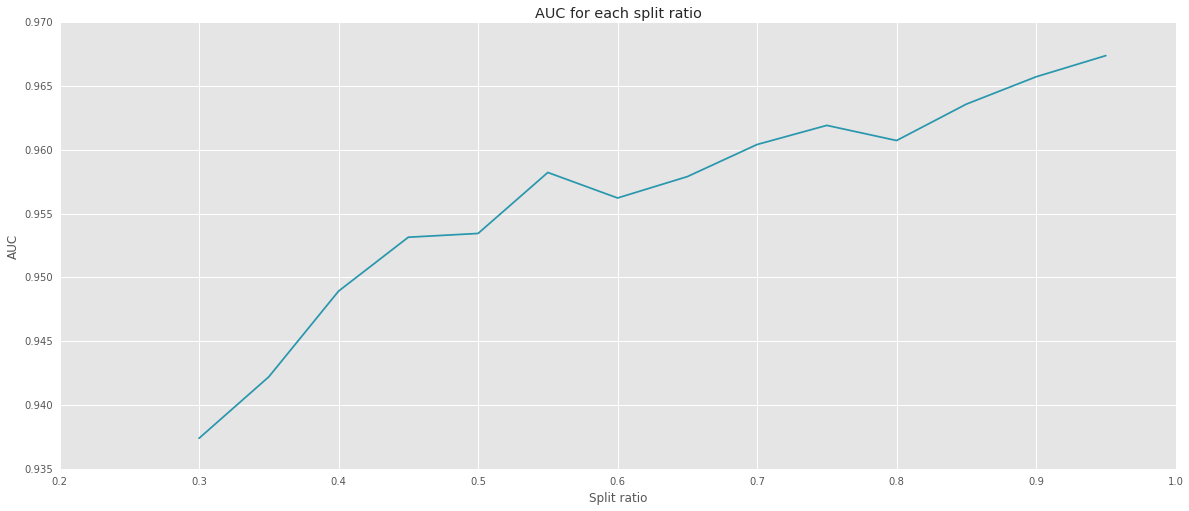

In [24]:
plt.plot(x, auc, color='#2997ad')
plt.xlabel('Split ratio')
plt.ylabel('AUC')
plt.grid(True, which='both', ls='-')
plt.title('AUC for each split ratio')
plt.show()

We can see that, as expected, the accuracy of the recommendation increases as the training set is increasing. Anyway, it is probably not a good idea using a ratio such as 0.95:0.05 (or even a bigger training set) because the test wouldn't be reliable, it would be performed with too few data.

# 4. Our recommendation system: an Interest-based approach

## 4.1 Introduction

We wanted to implement a new algorithm, trying to improve the one given as "hint" for this notebook, and we have taken into account several possibilities: first of all, we wanted to move away from a pure Collaborative-filtering approach using some metadata about each artist (e.g genre, year, country, ...) to implement a content-based algorithm, but we have encountered some problem (the script to extract all the metadata is still running...).
Thus, we decided to use a collaborative-filtering approach, but changing some of the aspects we did not like about the original algorithm: for instance, it tends to recommend popular aritsts, even to people that are more oriented to underground music, and it doesn't take into account the curiosity of a given user.

## 4.2 Interest

Our approach has been using the same algorithm but, while looking for "similar users", we focus on the `interest` of a user in a given artist instead of just focusing on the number of PlayCount, the interest of a certain user in artist `aID` is defined as:
$$interest_{aID}=\frac{playCount_{aID}}{totalPlayCount}$$

## 4.3 The implementation of ALS with interest

We pass the interest as parameter to the ALS to generate a model for producing recommendations. Then we'll compute the AUC for the new model and compare it with the previuos method.

In [40]:
userTotalPlay = userArtistDataRDD.map(lambda x: (x[0], int(x[2]))).reduceByKey(lambda a, b: a + b).collectAsMap()
bUserTotalPlay = sc.broadcast(userTotalPlay)

In [41]:
def applyInterest(user):
    [userID, artistID, count] = user
    userPlayCount = bUserTotalPlay.value.get(userID)
    return (userID, artistID, int(count) / int(userPlayCount))

userArtistInterestRDD = userArtistDataRDD.map(applyInterest).cache()
allData = userArtistInterestRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(sc.defaultParallelism).cache()

t0 = time()
model = ALS.trainImplicit(allData, rank, iterations, lambda_ = lambda_, alpha = alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 170.096375 secs


In [42]:
# Make five recommendations to user 2093760
recommendations = model.recommendProducts(2093760, 5)

# construct set of recommendated artists
recArtist = set([x[1] for x in recommendations])

# construct data of artists (artist_id, artist_name)
artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()

print(recList)

['Nikkfurie de La Caution', 'Die Ärzte', 'Silvertide', 'Unknown', 'Böhse Onkelz']


Looking at these results, we have just discovered that the clean-up of the data we have performed was not enough. Indeed, there are still in the datasets several `unknown` that has not been renamed to `[unknown]` while removing the mispelled artists.

The results don't differ much from the other recommender algorithm.

In [43]:
rank = 10
iterations = 5
lambda_ = 0.01
alpha = 1.0

In [54]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit(trainData, rank, iterations, lambda_ = lambda_, alpha = alpha)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 138.395748 secs


Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

In [45]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9625028224610496
finish in 37.812778 seconds


In [46]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank, iterations, lambda_ = lambda_, alpha = alpha)
            auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)

            evaluations.append(((rank, lambda_, alpha), auc))

            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [47]:
evaluations.sort(key = lambda x: x[1], reverse = True)

evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0     (50, 1.0, 40.0)  0.975585
1     (10, 1.0, 40.0)  0.971077
2      (50, 1.0, 1.0)  0.961026
3   (10, 0.0001, 1.0)  0.960974
4  (10, 0.0001, 40.0)  0.960586
5  (50, 0.0001, 40.0)  0.940809
6   (50, 0.0001, 1.0)  0.938239
7      (10, 1.0, 1.0)  0.835510


PythonRDD[3183] at RDD at PythonRDD.scala:48

The best parameters, `rank`, `lambda_`, `alpha`, are given by: `50, 1.0, 40.0`

In [58]:
rank = 50
lambda_ = 1.0
alpha = 40.0

model = ALS.trainImplicit(allData, rank, iterations, lambda_ = lambda_, alpha = alpha)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(2093760,5)

recommendedProductIDs = set( [x[1] for x in recommendations] )

recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()
print(recList)

['Nikkfurie de La Caution', 'Die Ärzte', 'Silvertide', 'Unknown', 'Böhse Onkelz']


Previously we recommended: `['50 Cent', 'Jay-Z', 'Ludacris', '2Pac', 'The Game']`

We can notice that the recommendation made with the *optimized* parameters changes.

We again consider one of the user with the highest curiosity, one with few play counts and one in between, picked randomly.

| UserID | Profile |
|---------|--------|
| 1024631 | very high artist count |
| 1008961 | low play count, low artist count |
| 2017397 | high playcount, low artist count

In [59]:
users = [ 1024631, 1008961, 2017397 ]
for user in users:
    recommendations = model.recommendProducts(user, 5)
    recommendedProductIDs = set([x[1] for x in recommendations])
    
    artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
    playedProductIDs = set(allData.filter(lambda x: x[0] == user).map(lambda x: x[1]).collect())

    userList = artistByID.filter(lambda x: x[0] in playedProductIDs).values().collect()
    recList = artistByID.filter(lambda x: x[0] in recommendedProductIDs).values().collect()

    #print('What the user %s listened to:' % user, userList)
    print('What the user %s should listen to:' % user, recList)

What the user 1024631 should listen to: ['Nightwish', '[unknown]', 'Die Ärzte', 'Rammstein', 'Green Day']
What the user 1008961 should listen to: ['Nightwish', 'Rammstein', 'Unknown', 'Green Day', 'Böhse Onkelz']
What the user 2017397 should listen to: ['Nightwish', 'Die Ärzte', 'Rammstein', 'Green Day', 'Böhse Onkelz']


In [ ]:
unpersist(model)

Unfortunately, our new *normalized* dataset generates recommendations very similar to each other, even if our theorethical accuracy, calculated with AUC, is very high. This test has shown us that normalizing data doesn't always lead to better results. Our attempt tried to reduce the difference between very popular artists and less popular one, by giving to each artist only a *rank*, or as we called it *interest*, which was a number between 0 and 1, between himself and an user.

## 4.4 Our algorithm: the math behind it

When we have to perform a recommendation for a given `userID` we look at the distance between that user and all the other users, and take into account the closest users (the amount of users we take into account varies, we will explain later how). We calculate the `distance` between two give users `a` and `b` as the square root of the sum of the quadratic difference of the `interest` of the two users over all the artists they (i.e. at least one of the two users) have been listening to:

$$d_{ab} = \sqrt{ \sum_{i \in S}{ (interest_{ai} - interest_{bi})^2 } }$$

where $$S = S_a \cup S_b$$

and they represent the set of artists user `a` and user `b`, respectively, have been listening to.

In principle, our method, is something similar to k-Nearest Neighbor algorithm, where $k$ is variable depending on how many recommendations we want to make. We search the user space for the most similar user and we suggest artists that our user hasn't listened to yet. In case of *full match*, which means both users have listened to the same set of artists, we may move to next nearest user, until we find a sufficient number of suggestions.

In [48]:
userTotalPlay = userArtistDataRDD.map(lambda x: (x[0], int(x[2]))).reduceByKey(lambda a, b: a + b).collectAsMap()
bUserTotalPlay = sc.broadcast(userTotalPlay)

In [63]:
def applyInterest(user):
    [userID, artistID, count] = user
    userPlayCount = bUserTotalPlay.value.get(userID)
    return (userID, [(artistID, int(count) / int(userPlayCount))])

userArtistInterestRDD = userArtistDataRDD.map(applyInterest).reduceByKey(lambda a, b: a + b).cache()
user = userArtistInterestRDD.filter(lambda x: x[0] == str(2093760)).collect()[0]

In [72]:
import math, operator
from collections import Counter
from heapq import heappush, heappop

def listToDict(lst):
    d = {}
    for (a, b) in lst:
        d[a] = b
    return d

def distance(user, other):
    userArtists = Counter(listToDict(user[1]))
    userArtists.subtract(listToDict(other[1]))
    dist = math.sqrt(__builtin__.sum([x**2 for x in userArtists.values()]))
    return dist

heap = []
min_dist = 0xFFFFFFFFFFFFFFFF
for other in userArtistInterestRDD.collect():
    dist = distance(user, other)
    min_dist = __builtin__.min(dist, min_dist)
    heappush(heap, (dist, other[1]))

userArtist = set(map(lambda x: x[0], user[1]))
rec = set()
i = 0
while len(rec) < 5:
    recArtist = set([x[0] for x in heappop(heap)[1]])
    for artist in recArtist:
        if artist not in userArtist and len(rec) < 5:
            rec.add(artist)

recList = artistByID.filter(lambda x: str(x[0]) in rec).values().collect()

print(recList)

['Mustasch', 'Non Phixion', 'Lars Winnerbäck', 'Breaking Point', 'Twista']


In [73]:
user[1].sort(key = lambda x: x[1])
userArtist = list(map(lambda x: x[0], user[1]))
userList = artistByID.filter(lambda x: str(x[0]) in userArtist).values().collect()

print(userList)

['David Gray', 'Blackalicious', 'Jurassic 5', 'The Saw Doctors', 'Xzibit']


Our method is pretty naive, but it is interesting from an academical point of view. Unfortunately we couldn't implement a verification method: our idea of implementing a cross-validation was unfeasible since we are recommending new artists and it is very unlikely that, while splitting the data, in the testing set we have artists that are not present in the training set.

Anyway, looking at the recommended artists, the recommendation looks coherent with the artists the user has been listening to.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)

# Extra

Below, the script we tried to run for integrating *tags* in our dataset.

```python
import sys, csv
import musicbrainzngs as mb

def get_tags(artist_name):
    artist_list = mb.search_artists(artist=artist_name)['artist-list']
    if len(artist_list) > 0:
        sorted(artist_list, key=lambda row: len(row['tag-list']) if 'tag-list' in row else 0, reverse=True)
        tags = artist_list[0]['tag-list'] if 'tag-list' in artist_list[0] else []
        return list(map(lambda x: x['name'], tags))
    else:
        return []


def main(args):
    outputfile = open(args[2], 'w', newline='')
    with open(args[1], newline='') as csvfile:
        artists = csv.reader(csvfile, delimiter=',', quotechar='"')
        output = csv.writer(outputfile, delimiter='\t', quotechar='"')
        for row in artists:
            artist_id, artist_name = row[0], row[1]
            try:
                artist_tags = get_tags(artist_name)
                output.writerow([artist_id, artist_name, ','.join(artist_tags)])
                print(artist_tags)
            except:
                continue


if __name__ == "__main__":
    mb.auth("<user>", "<password>")
    mb.set_useragent("AML stat app", "0.1", "http://aml-lab.com/aml")
    mb.set_hostname("beta.musicbrainz.org")
    main(sys.argv)
```